In [84]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.utils import plot_model


from datetime import datetime
import datetime
import time
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image 
plt.style.use("seaborn")

from src.build_models import *
from src.plotting_funcs import *
from src.predict_funcs import *

In [3]:
train_generator229, validation_generator229 = create_data_gens(target_size=(229,229), train_dir = "../images/Images/train",  val_dir = '../images/Images/test', batch_size = 30)

train_generator, validation_generator = create_data_gens(target_size=(150,150), train_dir = "../images/Images/train",  val_dir = '../images/Images/test', batch_size = 30)

Found 4164 images belonging to 25 classes.
Found 185 images belonging to 25 classes.
Found 4164 images belonging to 25 classes.
Found 185 images belonging to 25 classes.


## Basic CNN

In [4]:
cnn_mod = load_model('models_and_weights/models/first_try_basiccnn150.h5')
loss1, acc1, top_k_acc1 = cnn_mod.evaluate(validation_generator)

1/1 [==============================] - 1s 1s/step - loss: 2.8589 - accuracy: 0.1568 - top_k_categorical_accuracy: 0.5243


## Xception Models

In [5]:
x_mod_150 = load_model('models_and_weights/models/Xception_mod150.h5')
loss2, acc2, top_k_acc2 = x_mod_150.evaluate(validation_generator)

1/1 [==============================] - 7s 7s/step - loss: 5.3634 - accuracy: 0.7405 - top_k_categorical_accuracy: 0.9081


In [6]:
plus_20_x_mod_150 = load_model('models_and_weights/models/plus_20_Xception_mod150.h5')
loss3, acc3, top_k_acc3 = plus_20_x_mod_150.evaluate(validation_generator)

1/1 [==============================] - 7s 7s/step - loss: 1.7623 - accuracy: 0.8108 - top_k_categorical_accuracy: 0.9514


##### Switch TO 229 target size

In [32]:
Xception_mod_229 = load_model('models_and_weights/models/Xception_mod3.h5')
loss4, acc4, top_k_acc4 = Xception_mod_229.evaluate(validation_generator229)

1/1 [==============================] - 43s 43s/step - loss: 1.0689 - accuracy: 0.8973 - top_k_categorical_accuracy: 0.9892


In [ ]:
#split next two cells to avoid crashing...BEST MODEL

In [30]:
Xception_mod_229_final = load_model('models_and_weights/models/Xception_mod3_run2.h5')

In [31]:
loss5, acc5, top_k_acc5 = Xception_mod_229_final.evaluate(validation_generator229)

1/1 [==============================] - 39s 39s/step - loss: 0.1167 - accuracy: 0.9730 - top_k_categorical_accuracy: 0.9946


## VGG16 Models

In [92]:
first_VGG16 = load_model('models_and_weights/models/18vgg16.h5')
loss6, acc6, top_k_acc6 = Xception_mod_229.evaluate(validation_generator229)

## ResNet Models

## Plot Models

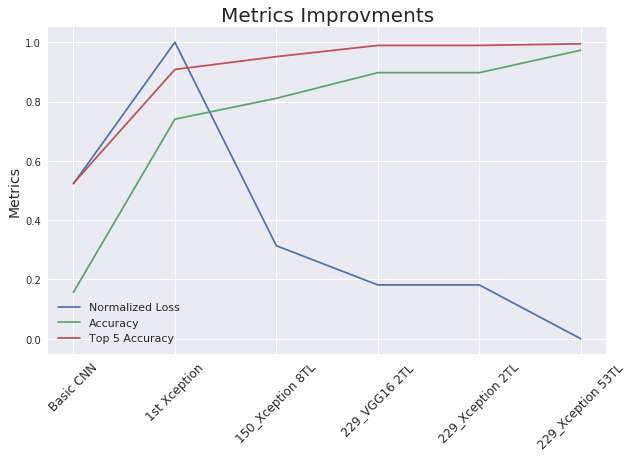

In [105]:
models_descripts = ['Basic CNN', '1st Xception', '150_Xception 8TL', '229_VGG16 2TL',
                    '229_Xception 2TL', '229_Xception 53TL']

losses = [loss1, loss2, loss3, loss6, loss4, loss5]
normalized_loss = (losses - min(losses))/(max(losses)-min(losses))

accuracys = [acc1, acc2, acc3, acc6, acc4, acc5]
top_ks = [top_k_acc1, top_k_acc2, top_k_acc3, top_k_acc6, top_k_acc4, top_k_acc5]


x = np.arange(1,7)
fig, ax = plt.subplots(1, figsize = (10,6))

ax.plot(x, normalized_loss, label = 'Normalized Loss')
ax.plot(x, accuracys, label = 'Accuracy')
ax.plot(x, top_ks, label = 'Top 5 Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models_descripts, rotation = 45,  fontsize = 12)
ax.set_ylabel('Metrics', fontsize = 14)
plt.legend(fontsize = 11)
plt.title('Metrics Improvments', fontsize = 20)
plt.savefig('visuals/model_improvements.png');

True- Chihuahua, 
Pred- Pekinese

True- Blenheim_spaniel, 
Pred- whippet

True- papillon, 
Pred- Japanese_spaniel



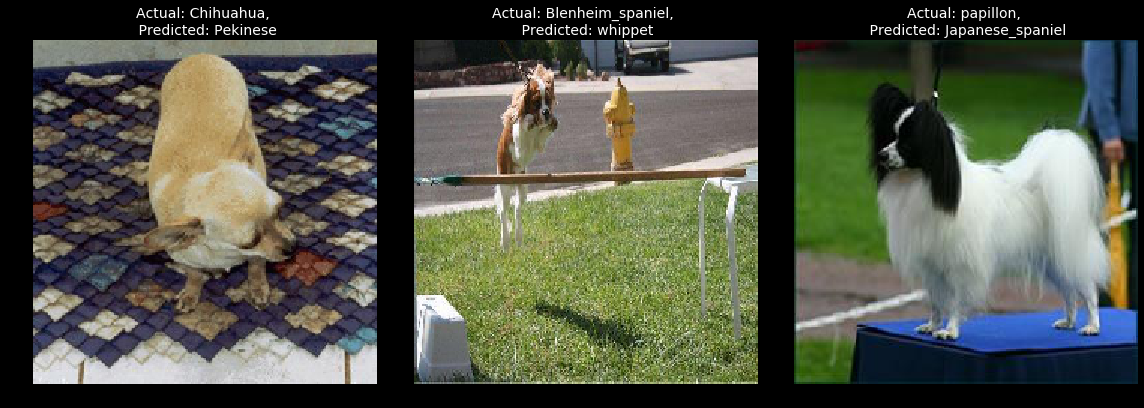

In [57]:
fig, axs = plt.subplots(1,3, figsize = (16,8))

plot_missclass(validation_generator, pred, axs = axs)
plt.tight_layout()
plt.savefig('visuals/wrong_pred.png')

In [345]:
rees_dir = '../../../animal_images/'

In [346]:
pred_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
pred_generator = pred_datagen.flow_from_directory(
        rees_dir,
        target_size=(229,229),
        batch_size=37,
        class_mode='categorical',
        shuffle = False,
        seed = 42)

Found 57 images belonging to 2 classes.


In [347]:
animal_preds = model.predict(pred_generator)
x,y = pred_generator.next()

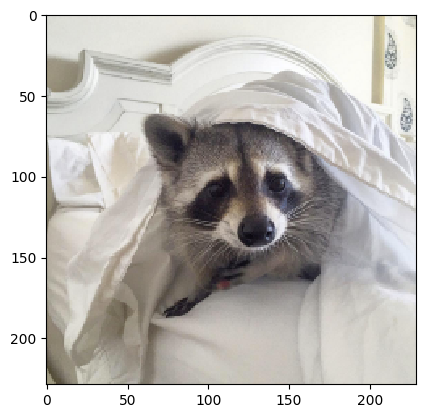

In [433]:
n = 3
plt.imshow(x[n])

In [434]:
labels = validation_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
animal_index = animal_preds[n].argsort()[::-1]
img_preds = []
for i in range(len(animal_index)):
    label = labels[animal_index[i]]
    img_preds.append(('-'.join(label.split('-')[1:])))

In [435]:
img_preds

['papillon',
 'Pekinese',
 'Chihuahua',
 'German_shepherd',
 'Japanese_spaniel',
 'whippet',
 'Doberman',
 'Shih-Tzu',
 'basset',
 'Labrador_retriever',
 'standard_schnauzer',
 'pug',
 'Boston_bull',
 'Rottweiler',
 'bloodhound',
 'Maltese_dog',
 'Blenheim_spaniel',
 'Rhodesian_ridgeback',
 'golden_retriever',
 'Great_Dane',
 'kuvasz',
 'chow',
 'Scotch_terrier',
 'English_setter',
 'standard_poodle']

In [348]:
final_preds = []
for img in range(21):
    labels = validation_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())
    animal_index = animal_preds[img].argsort()[::-1]
    img_preds = []
    for i in range(count):
        label = labels[animal_index[i]]
        img_preds.append(('-'.join(label.split('-')[1:])))
    final_preds.append(img_preds[:3])

In [389]:
Jamie = ['Boston_bull',
 'basset',
 'Chihuahua',  
 'whippet',
 'Blenheim_spaniel',
 'pug','pug',
 'Pekinese',
 'Chihuahua',  
 'whippet',
 'Shih-Tzu','Great_Dane',
 'whippet',
 'Labrador_retriever',
 'English_setter',
 'Boston_bull']

d = {}

for items in Jamie:
    if items not in d:
        d[items] = 1
    else:
        d[items] += 1

In [390]:
d

{'Blenheim_spaniel': 1,
 'Boston_bull': 2,
 'Chihuahua': 2,
 'English_setter': 1,
 'Great_Dane': 1,
 'Labrador_retriever': 1,
 'Pekinese': 1,
 'Shih-Tzu': 1,
 'basset': 1,
 'pug': 2,
 'whippet': 3}

In [231]:
Pemi = ['whippet', 'pug', 'Boston_bull', 'Chihuahua' ]
Rees = ['whippet', 'bloodhoud', 'basset', 'pug', 'rhodesian_ridgeback', 'great_dane']

In [31]:
# rees_dir = '../../../animal_images/'
# predicts = []
# for pic in lst:
#     img = pic
#     first_r_img = image.load_img(rees_dir+img, target_size = (229,229))
#     rees_img = image.img_to_array(first_r_img)
#     rees_img = np.expand_dims(rees_img,axis = 0)
#     rees_pred = model.predict(rees_img)
#     predicts.append(rees_pred)

In [170]:
d = {}
for i in train_generator.classes:
    if i not in d:
        d[i] = 1
    else:
        d[i] += 1

<BarContainer object of 25 artists>

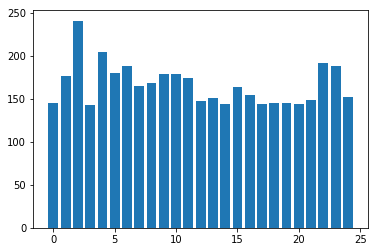

In [171]:
plt.bar(range(25), d.values())

In [172]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087394-Rhodesian_ridgeback': 7,
 'n02088238-basset': 8,
 'n02088466-bloodhound': 9,
 'n02091134-whippet': 10,
 'n02096585-Boston_bull': 11,
 'n02097209-standard_schnauzer': 12,
 'n02097298-Scotch_terrier': 13,
 'n02099601-golden_retriever': 14,
 'n02099712-Labrador_retriever': 15,
 'n02100735-English_setter': 16,
 'n02104029-kuvasz': 17,
 'n02106550-Rottweiler': 18,
 'n02106662-German_shepherd': 19,
 'n02107142-Doberman': 20,
 'n02109047-Great_Dane': 21,
 'n02110958-pug': 22,
 'n02112137-chow': 23,
 'n02113799-standard_poodle': 24}

In [ ]:
array([ 0,  0,  0,  0,  0,  3,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4, 10,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  1,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24])

In [173]:
labels = validation_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
lst = list(labels.values())
real_labels = ['-'.join(lab.split('-')[1:]) for lab in lst]


In [175]:
from tensorflow.math import confusion_matrix
predicted_class_indices = np.argmax(pred,axis=1)

real_classes = validation_generator.classes

conf_arry = confusion_matrix(real_classes, predicted_class_indices, num_classes=25 )

W0919 00:26:06.895503 140161098020608 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/confusion_matrix.py:194: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0919 00:26:06.897351 140161098020608 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/confusion_matrix.py:195: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [324]:
conf_arry = conf_arry.numpy()
df_cm = pd.DataFrame(conf_arry, index = [i for i in real_labels],
              columns = [i for i in real_labels])

In [326]:
df_cm = df_cm/df_cm[df_cm.columns].sum()*100

In [329]:
df_cm = df_cm.round()

In [176]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-dark-palette')

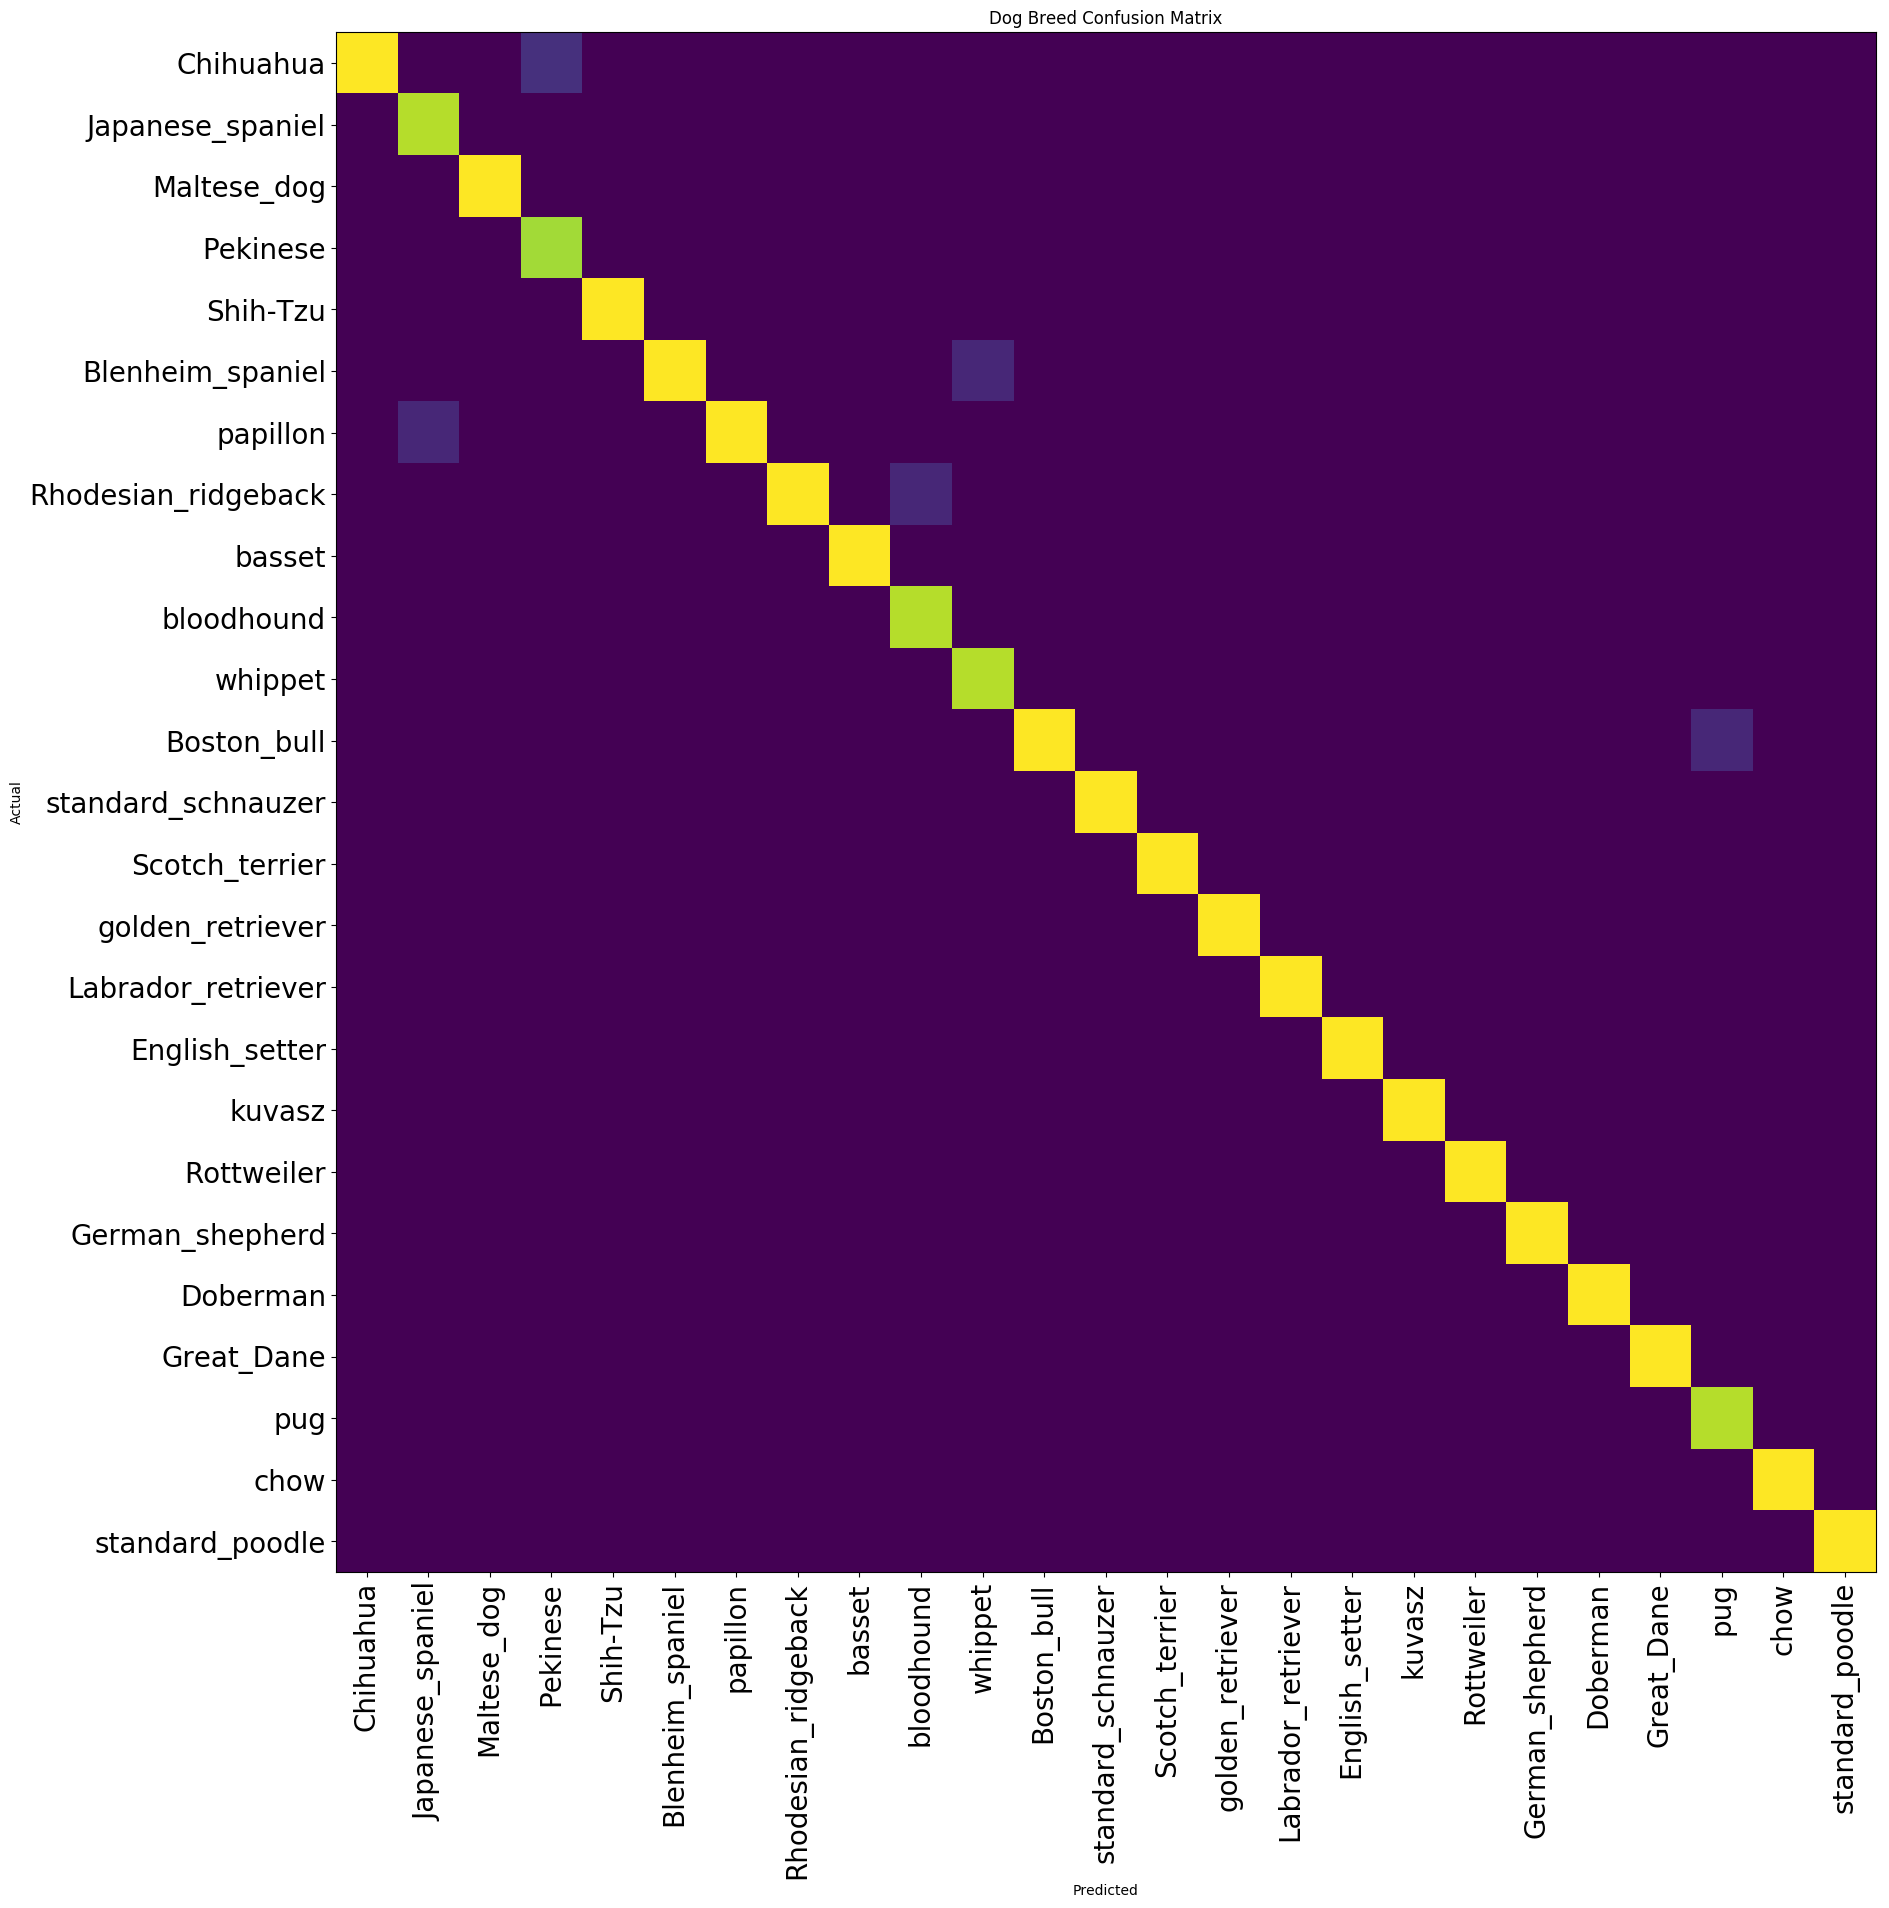

In [330]:
fig, ax = plt.subplots(1, figsize = (20,20))
ax.set_title('Dog Breed Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.imshow(df_cm)
ax.set_xticks(range(25))
ax.set_yticks(range(25))
ax.set_xticklabels(real_labels, rotation=90, fontsize=20)
ax.set_yticklabels(real_labels, fontsize=20)
plt.show()

In [436]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix

In [437]:
import seaborn as sns

In [438]:
confusion_arr = cm(real_classes, predicted_class_indices)
df_cm = pd.DataFrame(confusion_arr, index = [i for i in real_labels],
              columns = [i for i in real_labels])

In [439]:
df.round()

,Chihuahua,Japanese_spaniel,Maltese_dog,Pekinese,Shih-Tzu,Blenheim_spaniel,papillon,Rhodesian_ridgeback,basset,bloodhound,...,Labrador_retriever,English_setter,kuvasz,Rottweiler,German_shepherd,Doberman,Great_Dane,pug,chow,standard_poodle
Chihuahua,100.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Japanese_spaniel,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Maltese_dog,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pekinese,0.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shih-Tzu,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blenheim_spaniel,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
papillon,0.0,11.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rhodesian_ridgeback,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basset,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bloodhound,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [440]:
for i in range(25):
    int(df_cm.Chihuahua.iloc[1])

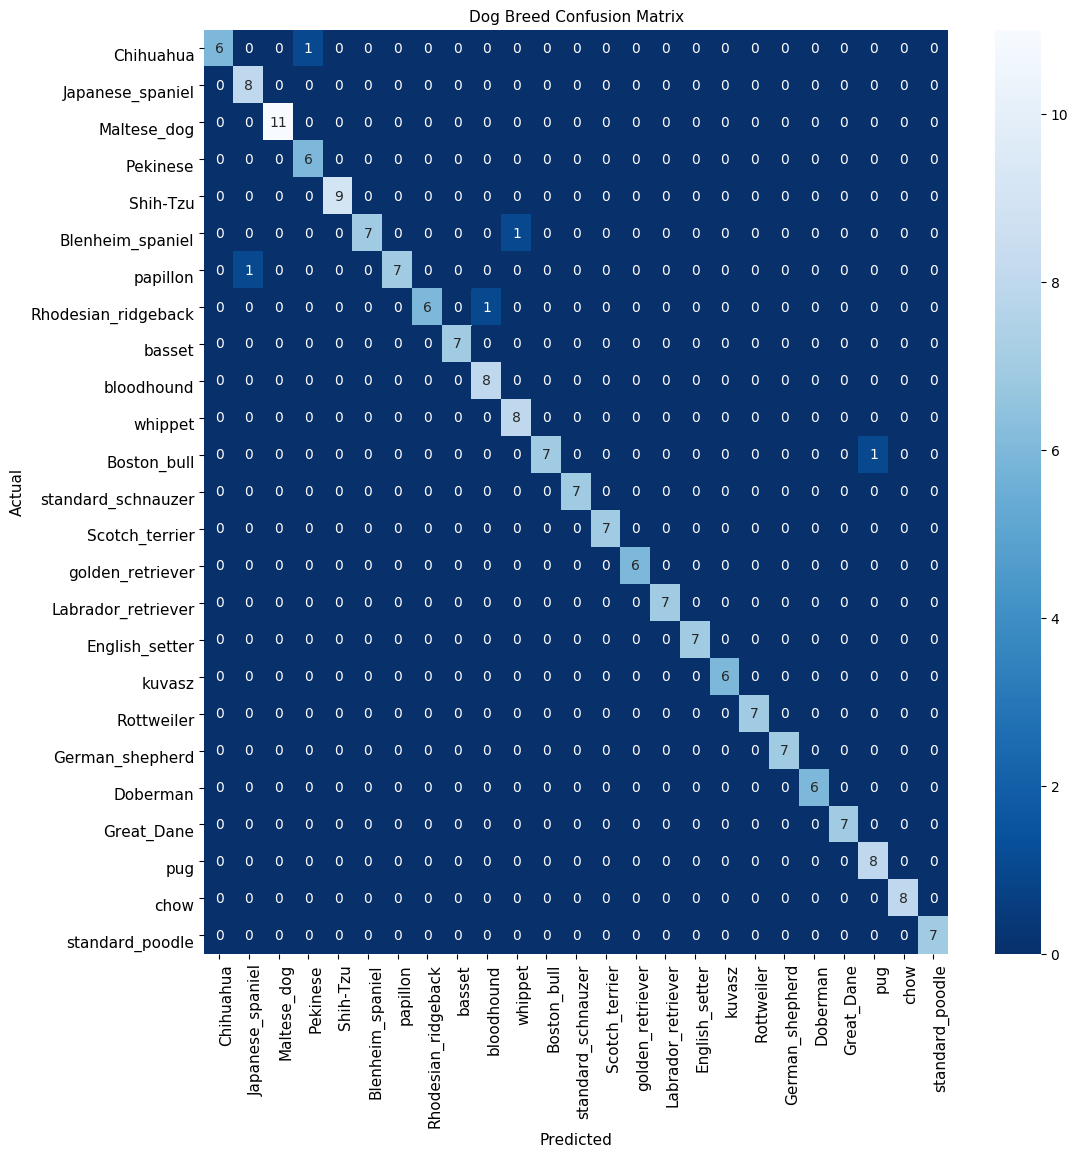

In [441]:
f_size = 11
fig, ax = plt.subplots(1, figsize = (12,12))
sns.heatmap(df_cm, annot=True,cmap="Blues_r", ax = ax)
ax.set_title('Dog Breed Confusion Matrix', fontsize=f_size)
ax.set_xlabel('Predicted', fontsize=f_size)
ax.set_ylabel('Actual', fontsize=f_size)
ax.set_xticklabels(real_labels, rotation=90, fontsize=f_size, ha='left')
ax.set_yticklabels(real_labels, fontsize=f_size, va = 'top')

plt.show()

In [ ]:
def plot_missclass(holdout_generator, predictions):
    x,y = holdout_generator.next()
    prediction_labels, real_labels = get_real_pred(predictions, holdout_generator)
    
    incorrect_index = find_missclass_indx(real_labels, prediction_labels)
    fig, axs = plt.subplots(4,2, figsize = (20,20))
    ax = axs.flatten()
    for i, ind in enumerate(incorrect_index):
        rl = real_labels[ind]
        pl = prediction_labels[ind]
        image = x[ind]
        ax[i].set_title('Actual: {}, \n Predicted: {}'.format(rl, pl))
        ax[i].imshow(image)
        ax[i].axis('off')